In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import time

In [2]:
class ImageSegmentation():
    
    def __init__(self, filepath='squares.jpg', num_classes=4, grayscale=False):
        """
        Initializes image segmentation object with filepath and 
        initial guess of num_classes
        """
        # Read in image, scale, and grayscale
        self.img = imread(filepath)
        img_max = np.max(self.img)
        self.img = self.img/img_max
        if grayscale == False:
            self.img = np.mean(self.img, axis = 2)
        
        
        # initialize n classes based on magnitude
        self.segmentation = self.img // ((256//num_classes)/img_max)
        
        #Initialize parameters for segmentation
        self.mu = [0]*num_classes
        self.sig = [1]*num_classes
        self.beta0 = [1]*num_classes
        self.beta1 = [1.5]*num_classes
        self.num_classes = num_classes
        
        
        # initialize the priors
        self.mu_variance = 1
        self.sig_variance = 1
        self.beta_variance = 1
        
        
    def show_init(self):
        """
        Function for printing off the initial picture and its initial 
        segmentation
        """
        # print img
        plt.imshow(self.img, cmap='gray')
        plt.show()
        
        # print segmentation, initial classes
        plt.imshow(self.segmentation, cmap='gray')
        plt.show()
        
        
    def segment(self, numiter=100, alpha=(1.1,1.5)):
        """
        Function for segmenting the image
        """
        for t in range(numiter):
            # Calculate current temperature
            T_t = (1 + alpha[0])**(alpha[1]*(1 - t/numiter))
            if t==0:
                T_t_old = T_t+1
            
            # Re-segment the image
            self.re_segment(T_t, alpha)
            
            # Sample noise parameters
            self.sample_noise(T_t, T_t_old)
            
            # Sample MRF parameters
            self.sample_MRF(T_t, T_t_old)
            
            # Sample number of classes
            # self.sample_num_classes()
            
            T_t_old = T_t
            
            plt.imshow(self.segmentation,cmap='gray')
            plt.title('Iteration {}'.format(t))
            plt.show()
            
        return self.segmentation
            
            
    def re_segment(self, T_t, alpha):
        """
        Returns the segmentation array by computing the probability
        of each pixel being in each class and returning the argmax
        """
        probs = np.zeros((self.num_classes, self.img.shape[0], self.img.shape[1]))
    
        for c in range(self.num_classes):
            
            # Compute the probabilities for this class
            probs[c] = 1/np.sqrt(2*np.pi*T_t*self.sig[c]**2)*np.exp(
                          -1/T_t*(0.5*((self.img - self.mu[c])/self.sig[c])**2 
                          + (self.beta0[c] + self.beta1[c]*self.V(c)))
                       )

        self.segmentation = np.argmax(probs, axis=0)
    
    
    def sample_noise(self, T_t, T_t_old):
        """Samples the noise model parameters.
        The output is a dictionary with these keys:
        {
         'mu': an array with the mean for each class
         'sig': an array with the st. dev. for each class
        }"""

        for c in range(self.num_classes):
            # Get pixels in class
            img_c = np.ravel(self.img[np.where(self.segmentation==c)])

            # Sample noise parameters
            mu_sample = np.random.normal(0, self.mu_variance)
            sig_sample = np.random.normal(0, self.sig_variance)

            # Calculate likelihood ratio
            ratio = self.noise_acceptance_ratio(img_c, (self.mu[c], self.sig[c], T_t_old), (mu_sample, sig_sample, T_t))

            # Accept or reject new parameters
            self.mu[c],self.sig[c] = self.accept(ratio, (self.mu[c], self.sig[c]), (mu_sample,sig_sample))

    
    def sample_MRF(self, T_t, T_t_old):
        """
        
        """
        
        for c in range(self.num_classes):
            
            # Get pixels in class
            v_vals = self.V(c).reshape(-1)
            c_idx = np.where(self.segmentation==c)[0]

            # Sample noise parameters
            beta_sample = np.random.normal(0, self.beta_variance)

            # Calculate likelihood ratio
            ratio = self.mrf_acceptance_ratio(c_idx, v_vals, (self.beta0[c], T_t_old), (beta_sample, T_t), c)

            # Accept or reject new parameters
            beta = self.accept(ratio, self.beta0[c], beta_sample)

            # Save parameters
            self.beta0[c] = beta
    
    
    def sample_num_classes(self):
        pass
    
    
    
    ## HELPER FUNCTIONS
    
    def V(self, c):
        # put ones and zeros in appropriate places
        mask = -((self.segmentation == c) - 1/2) * 2
        
        # create a matrix for padding our image
        new = np.zeros((self.segmentation.shape[0]+2, self.segmentation.shape[1]+2))
        
        # pad the image
        new[0,1:-1] = mask[1,:]
        new[-1,1:-1] = mask[-2,:]
        new[1:-1,0] = mask[:,1]
        new[1:-1,-1] = mask[:,-2]
        new[1:-1, 1:-1] = mask
        
        # sum across 4 neighbors of each pixel
        v = new[:-2,1:-1] + new[1:-1, :-2] + new[2:,1:-1] + new[1:-1,2:]
        return v/4
    
    
    def accept(self, ratio, old_sample, new_sample): 
        if ratio > 1:
            # always accept
            output = new_sample
        else:
            # accept w/ probability ratio
            draw = np.random.random()
            if draw < ratio:
                # accept
                output = new_sample
            else:
                # reject
                output = old_sample

        return output
    
    
    def noise_acceptance_ratio(self, img_c, old_params, new_params):
        mu_old, sig_old, T_old = old_params
        mu_new, sig_new, T_new = new_params

        ratios = []
        for s in img_c:
            new_likelihood = 1/(sig_new**2*T_new) * np.exp(-1/(2*T_new) * ((s - mu_new)/sig_new)**2)
            old_likelihood = 1/(sig_old**2*T_old) * np.exp(-1/(2*T_old) * ((s - mu_old)/sig_old)**2)
            ratios.append(new_likelihood/old_likelihood)

        acc_ratio = np.prod(np.array(ratios))
        return acc_ratio

    def mrf_acceptance_ratio(self, idx, v_vals, old_params, new_params, c):
        beta_old, T_t_old = old_params
        beta_new, T_t = new_params
        beta_1 = 1.5

        ratios = []

        for s in idx:
            new_likelihood_denom = np.sum([np.exp(-1/T_t * (beta_new + self.beta1[c] * v_vals[s])) for i in range(self.num_classes)])
            old_likelihood_denom = np.sum([np.exp(-1/T_t_old * (beta_old + self.beta1[c] * v_vals[s])) for i in range(self.num_classes)])

            new_likelihood = np.exp(-1/T_t*(beta_old + self.beta1[c] * v_vals[s])) / new_likelihood_denom
            old_likelihood = np.exp(-1/T_t_old*(beta_old + self.beta1[c] * v_vals[s])) / old_likelihood_denom

            ratios.append(new_likelihood/old_likelihood)

        acc_ratio = np.prod(np.array(ratios))
        return acc_ratio
    
    
    

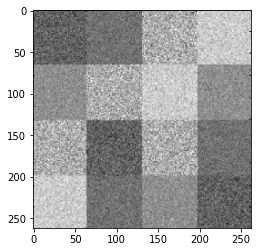

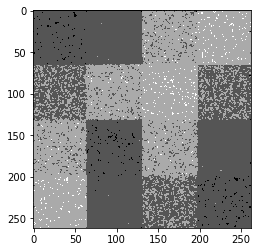

In [4]:
image = ImageSegmentation(num_classes=4)
image.show_init()

/Users/mckayharward/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


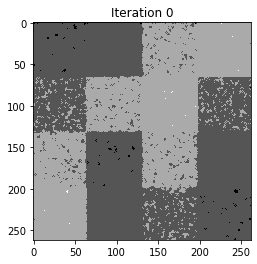

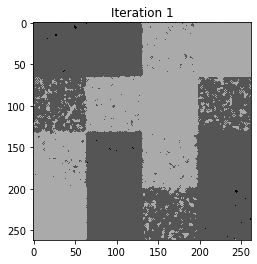

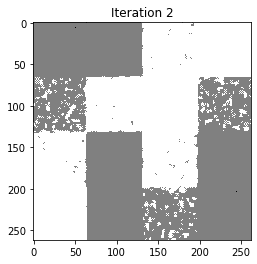

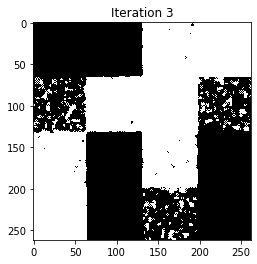

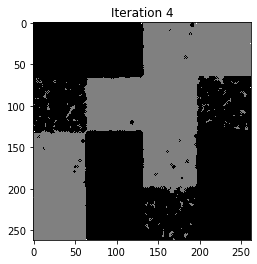

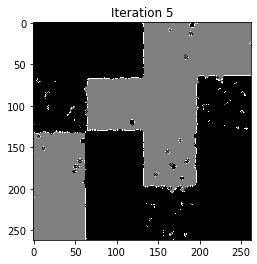

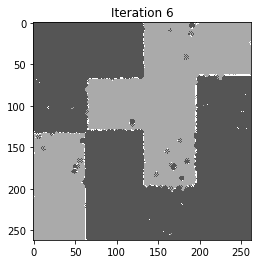

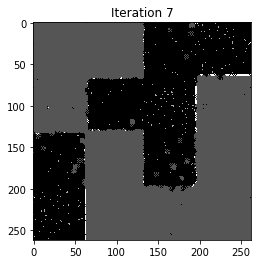

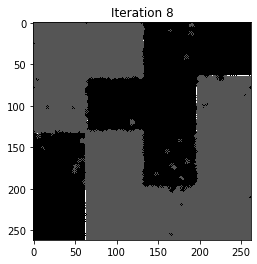

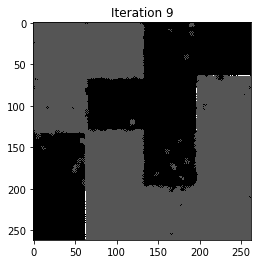

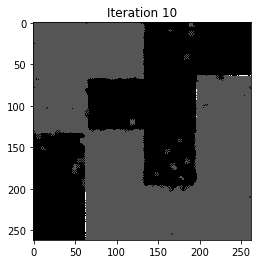

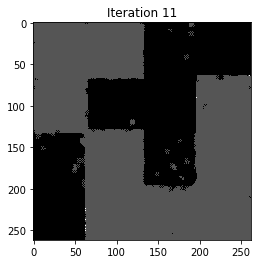

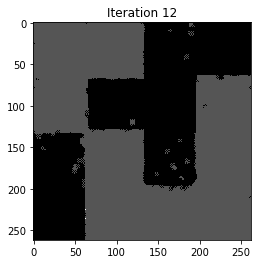

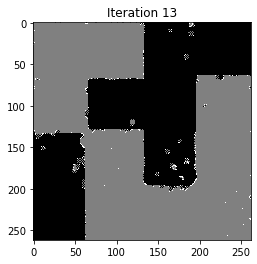

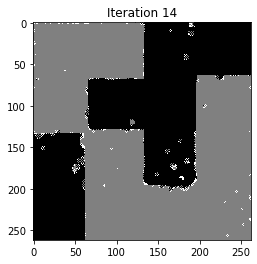

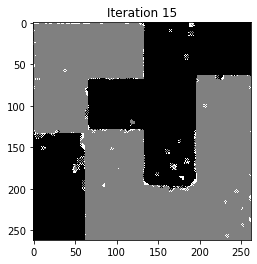

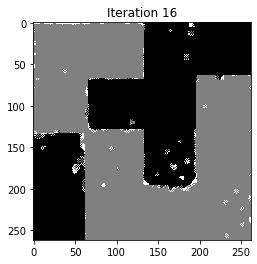

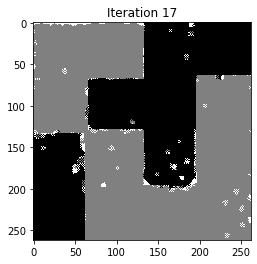

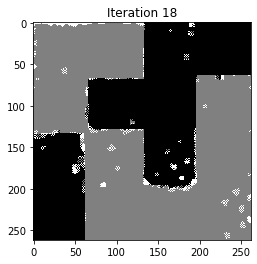

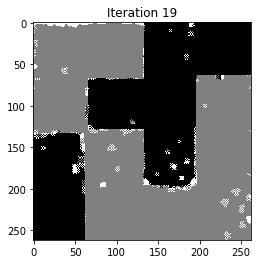

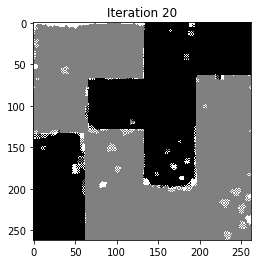

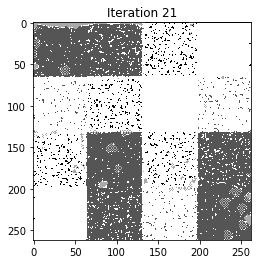

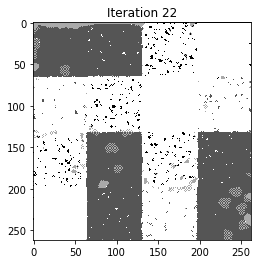

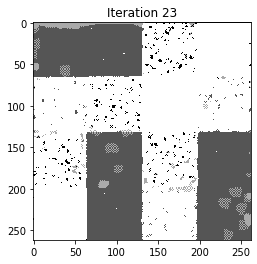

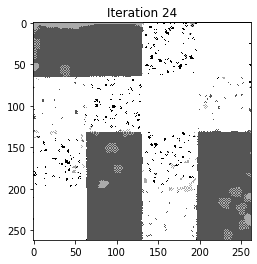

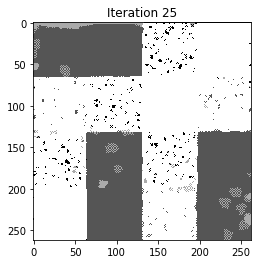

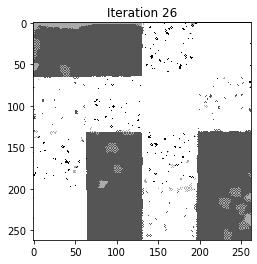

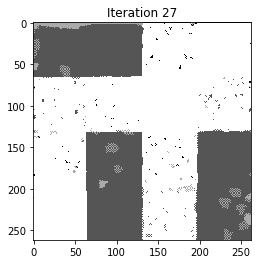

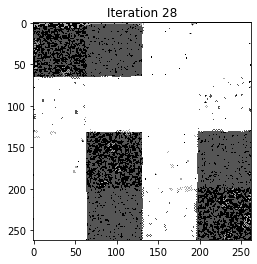

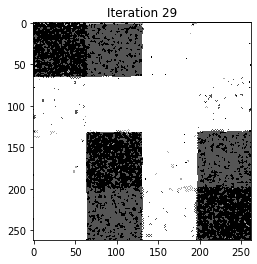

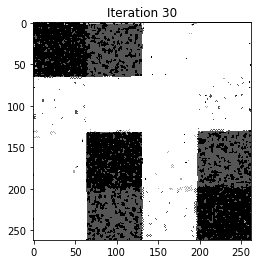

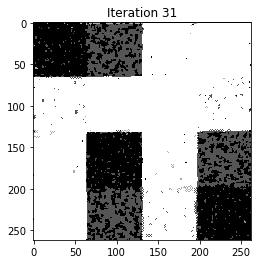

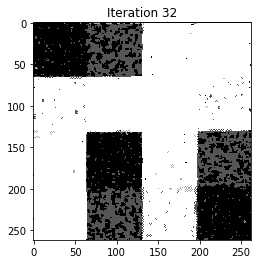

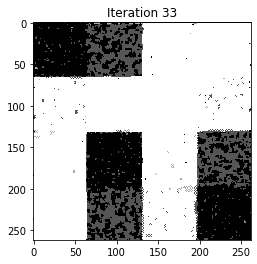

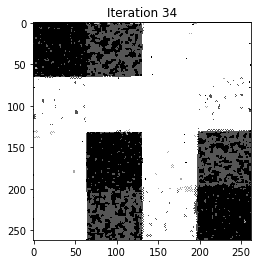

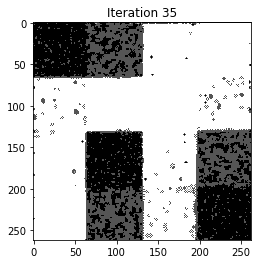

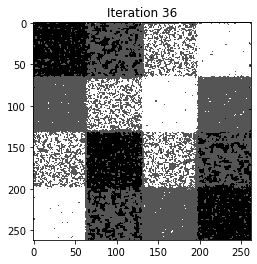

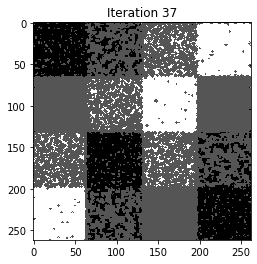

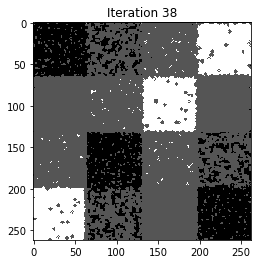

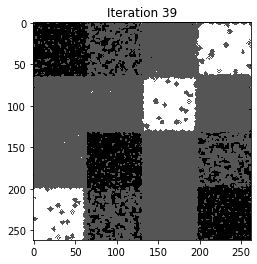

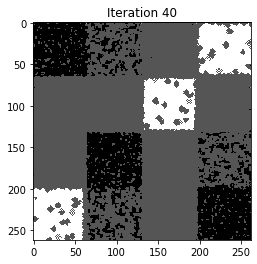

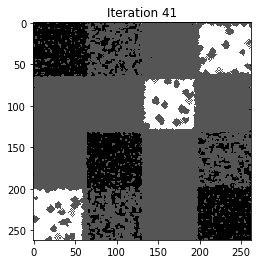

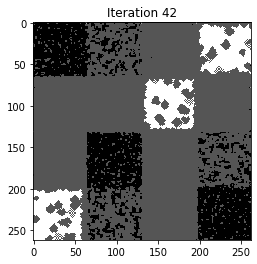

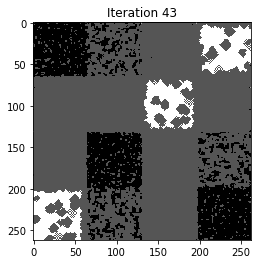

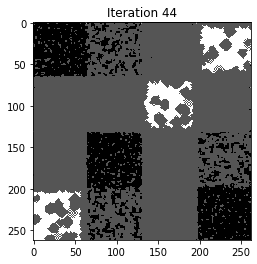

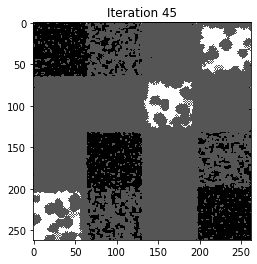

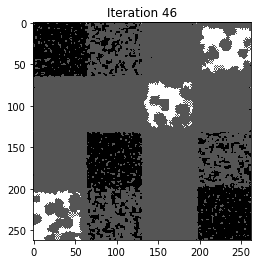

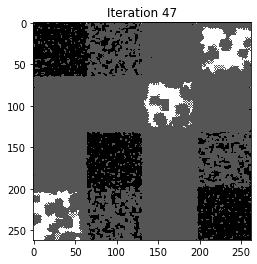

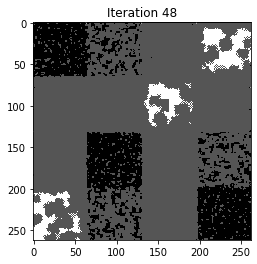

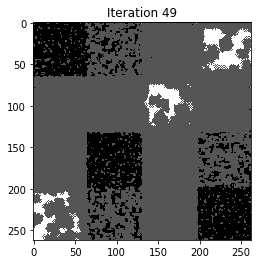

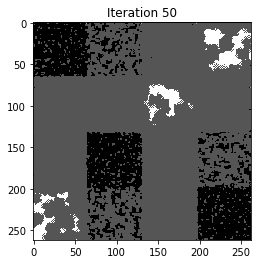

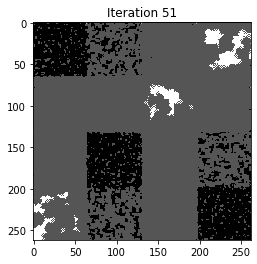

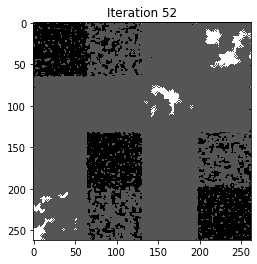

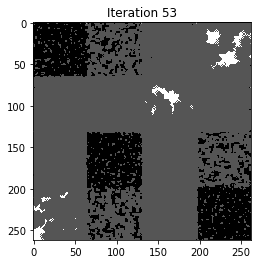

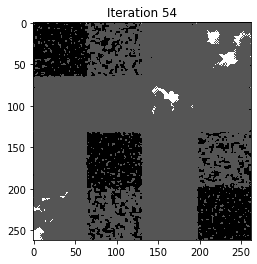

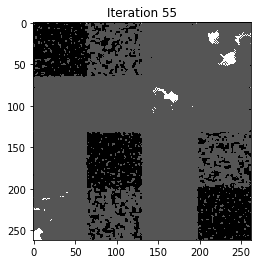

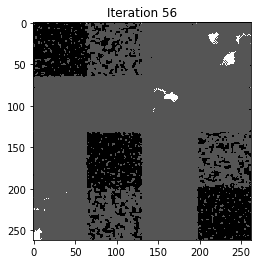

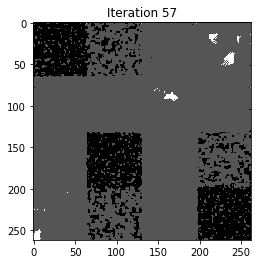

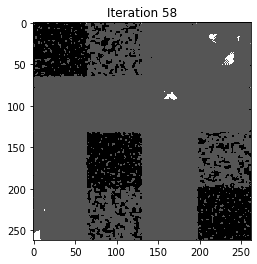

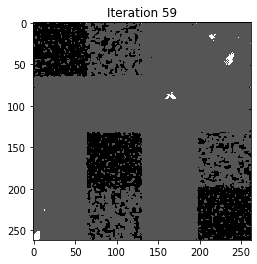

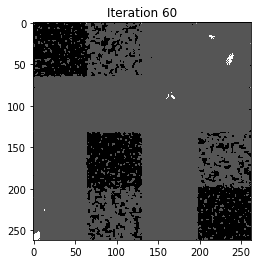

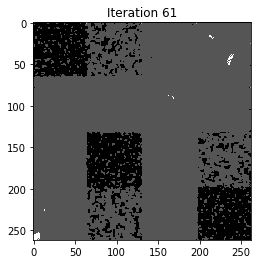

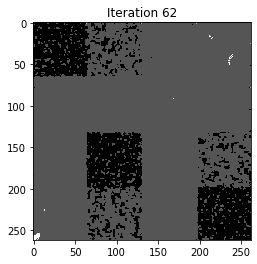

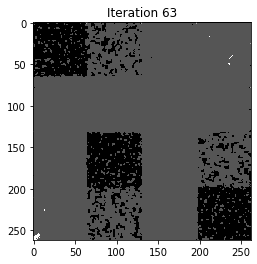

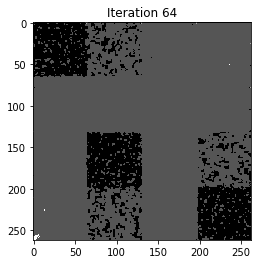

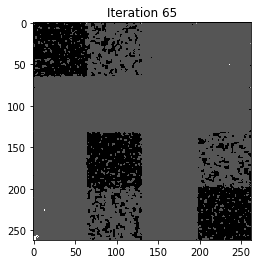

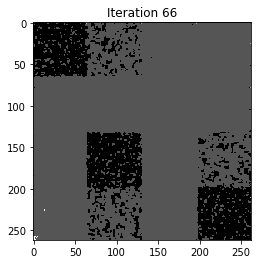

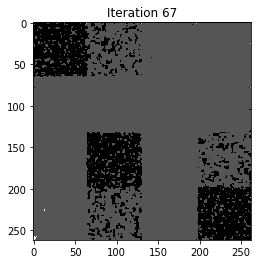

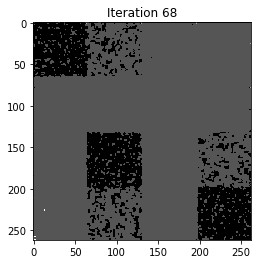

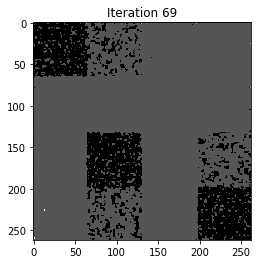

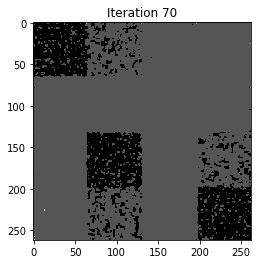

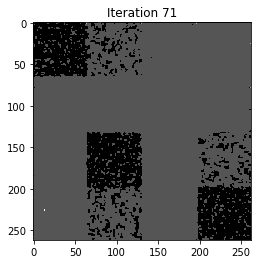

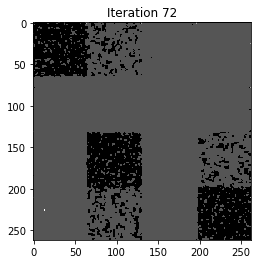

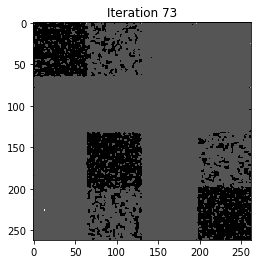

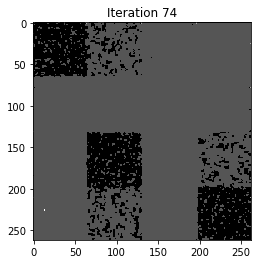

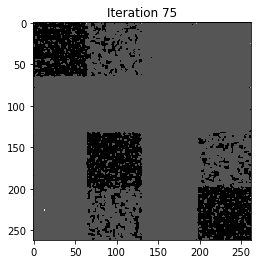

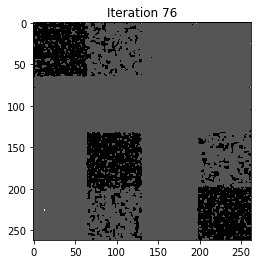

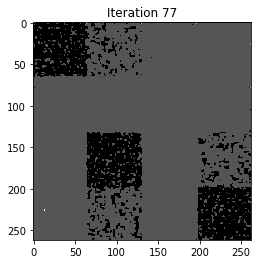

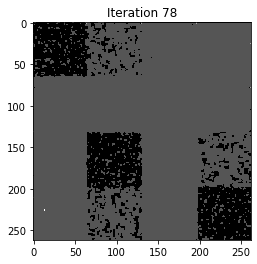

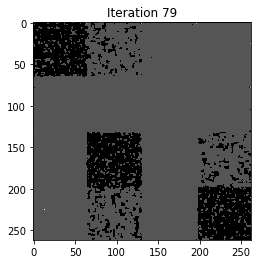

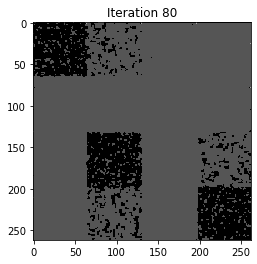

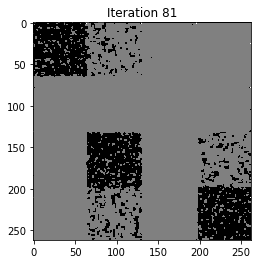

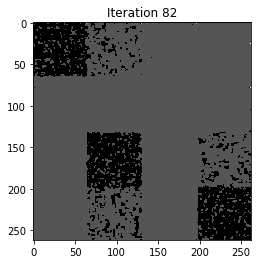

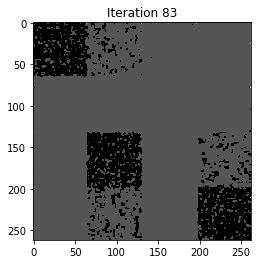

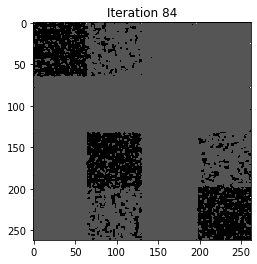

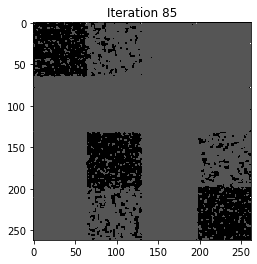

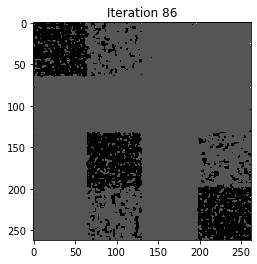

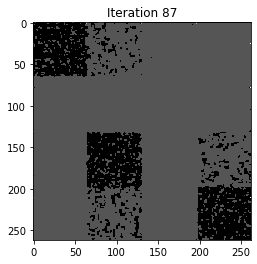

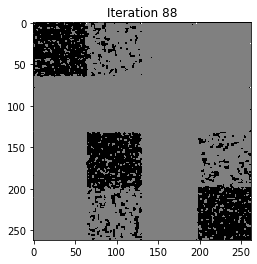

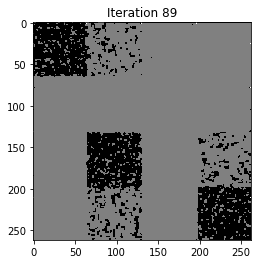

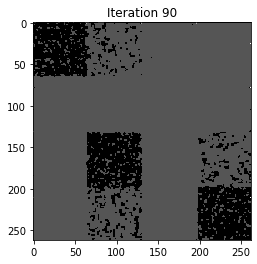

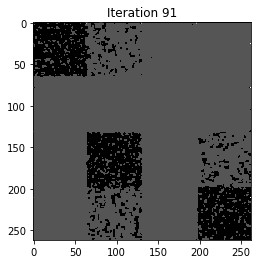

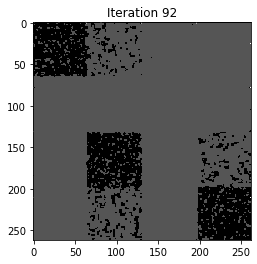

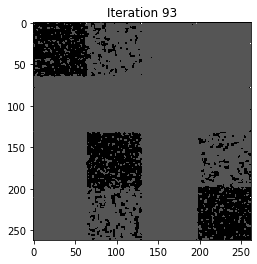

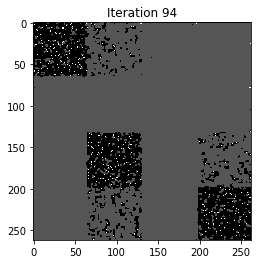

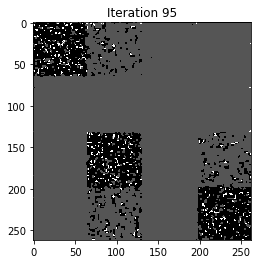

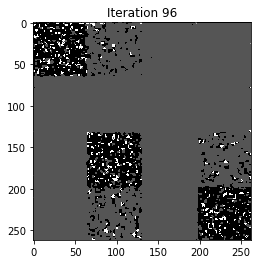

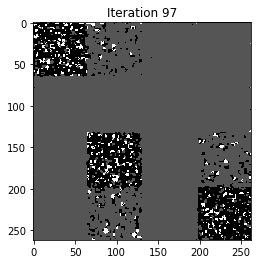

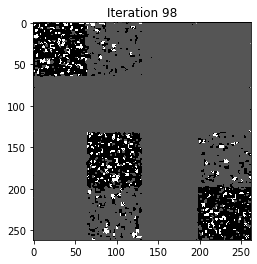

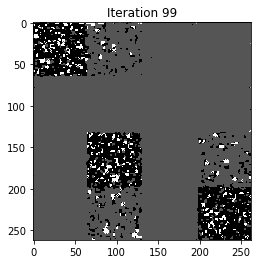

array([[3, 3, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [5]:
image.segment()